In [74]:
#Librairie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Activation


from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Sequential
import tensorflow as tf





In [24]:
# Configuration (si GPU disponible)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs disponibles: {len(gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("Aucun GPU détecté, utilisation du CPU.")

Aucun GPU détecté, utilisation du CPU.


In [25]:
# chargement des données
base_path = r"ENetFall_dataset_trained_networks"

dataset_files = [
    r"dataset_home_lab(L).mat",
    r"dataset_home_lab(R).mat",
    r"dataset_lecture_room.mat",
    r"dataset_living_room.mat",
    r"dataset_meeting_room.mat"
]

signals = []
labels = []

for file_name in dataset_files:
    path = fr"{base_path}\{file_name}"
    try:
        data_mat = sio.loadmat(path)
        signals.append(data_mat['dataset_CSI_t'])
        labels.append(data_mat['dataset_labels'].squeeze())
        print(f"Chargé: {file_name}, Signaux: {data_mat['dataset_CSI_t'].shape}, Étiquettes: {data_mat['dataset_labels'].squeeze().shape}")
    except Exception as e:
        print(f"Erreur avec {path}: {e}")

if not signals:
    raise ValueError("Aucune donnée n'a été chargée.")

data_all = np.concatenate(signals, axis=0)
labels_all = np.concatenate(labels, axis=0)

print(f"\nDonnées totales - signaux: {data_all.shape}, étiquettes: {labels_all.shape}")

Chargé: dataset_home_lab(L).mat, Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_home_lab(R).mat, Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_lecture_room.mat, Signaux: (205, 625, 90), Étiquettes: (205,)
Chargé: dataset_living_room.mat, Signaux: (248, 625, 90), Étiquettes: (248,)
Chargé: dataset_meeting_room.mat, Signaux: (134, 625, 90), Étiquettes: (134,)

Données totales - signaux: (757, 625, 90), étiquettes: (757,)


#### 1. On considére les 22 participants et les 4 environnements comme connus et on les intégre dans l’entrainement.

In [26]:
# prétraitement des données

# Reshape pour CNN: (Nombre d'échantillons, Hauteur, Largeur, Canaux)
# c'est ce qui est attendu en entrée dans un CNN
# (N, 625, 90) -> (N, 625, 30, 3) après réorganisation et transposition
instances = data_all.shape[0]
timesamples = data_all.shape[1] # 625
subcarriers = data_all.shape[2] # 90
width = subcarriers // 3 # 30

data = np.ndarray(shape=(instances, 3, timesamples, width))
data[:, 0, :, :] = data_all[:, :, 0:subcarriers:3]
data[:, 1, :, :] = data_all[:, :, 1:subcarriers:3]
data[:, 2, :, :] = data_all[:, :, 2:subcarriers:3]

# Transposer pour TensorFlow: (N, timesamples, width, 3)
data_tf = np.transpose(data, (0, 2, 3, 1))
print(f"Forme des données pour TensorFlow: {data_tf.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    data_tf, labels_all,
    test_size=0.25,
    random_state=42,
    stratify=labels_all
)



Forme des données pour TensorFlow: (757, 625, 30, 3)


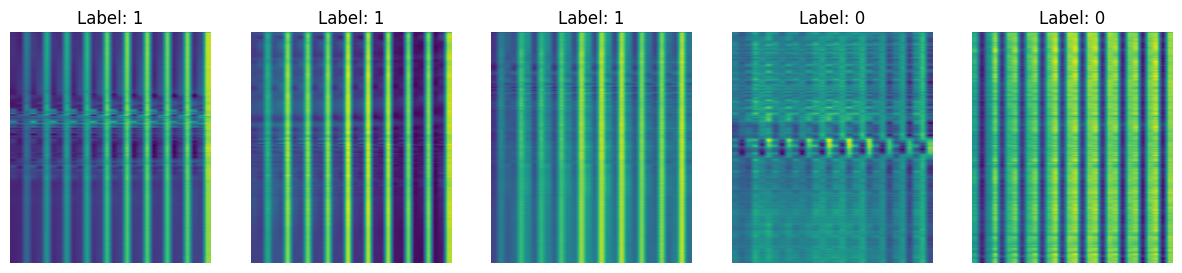

In [27]:
#Test affichage de données

import matplotlib.pyplot as plt

def afficher_exemples(X, y, n=5):
    """
    Affiche n exemples de données d'entraînement.
    X : données (N, 625, 30, 3)
    y : labels (N,)
    n : nombre d'exemples à afficher
    """
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i, :, :, 0], aspect='auto', cmap='viridis')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.show()

afficher_exemples(X_train, y_train)

In [35]:
#normalisation
train_max = np.max(X_train)
train_mean = np.mean(X_train / train_max)

X_train_normalized = (X_train / train_max) - train_mean
X_test_normalized = (X_test / train_max) - train_mean

#séparation des données
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_normalized)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_normalized, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

input_shape = X_train_normalized.shape[1:]

#Modèle 1 : CNN 3 couches de convolution 

model_1 = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid') 
])

model_1.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
)
model_1.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 623, 28, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 311, 14, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 309, 12, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 154, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 152, 4, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 38912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     2,490,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546,817 (9.72 MB)

 Trainable params: 2,546,817 (9.72 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
#Entrainement modèle 1

epochs = 30

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = model_1.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

print("\nÉvaluation sur l'ensemble de test:")
results = model_1.evaluate(test_dataset)
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Precision: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.5747 - loss: 0.6746 - precision: 0.4943 - recall: 0.3188 - val_accuracy: 0.6000 - val_loss: 0.6706 - val_precision: 0.5532 - val_recall: 0.3210
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.6148 - loss: 0.6348 - precision: 0.5637 - recall: 0.3308 - val_accuracy: 0.6895 - val_loss: 0.6311 - val_precision: 0.6667 - val_recall: 0.5432
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6401 - loss: 0.6282 - precision: 0.6918 - recall: 0.3535 - val_accuracy: 0.6947 - val_loss: 0.5847 - val_precision: 0.8966 - val_recall: 0.3210
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.7023 - loss: 0.5638 - precision: 0.7254 - recall: 0.5416 - val_accuracy: 0.6947 - val_loss: 0.5565 - val_precision: 0.6825 - val_recall: 0.5309
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.7613 - loss: 0.5130 - precision: 0.7830 - recall: 0.6299 - val_accuracy: 0.7368 - val_loss: 0.

In [37]:
# Évaluation du modèle 1 phase1
results_model_1 = []
model_name = "CNN simple"

print(f"Évaluation de : {model_name}")

eval_train = model_1.evaluate(X_train_normalized, y_train.astype(np.float32), verbose=0)
results_model_1.append({
    "Modèle": model_name,
    "Set": "Train",
    "Loss": f"{eval_train[0]:.4f}",
    "Accuracy": f"{eval_train[1]:.4f}",
    "Precision": f"{eval_train[2]:.4f}",
    "Recall": f"{eval_train[3]:.4f}"
})


eval_test = model_1.evaluate(X_test_normalized, y_test.astype(np.float32), verbose=0)
results_model_1.append({
    "Modèle": model_name,
    "Set": "Test",
    "Loss": f"{eval_test[0]:.4f}",
    "Accuracy": f"{eval_test[1]:.4f}",
    "Precision": f"{eval_test[2]:.4f}",
    "Recall": f"{eval_test[3]:.4f}"
})


df_results_model_1 = pd.DataFrame(results_model_1)

print("\n\nTableau Récapitulatif des Performances du Modèle 1:\n")
print(df_results_model_1.to_markdown(index=False))


Évaluation de : CNN simple


Tableau Récapitulatif des Performances du Modèle 1:

| Modèle     | Set   |   Loss |   Accuracy |   Precision |   Recall |
|:-----------|:------|-------:|-----------:|------------:|---------:|
| CNN simple | Train | 0.3035 |     0.8571 |      0.8412 |   0.8167 |
| CNN simple | Test  | 0.3936 |     0.8316 |      0.7952 |   0.8148 |


In [ ]:
#Modèle hybride avec MobileNet et Couche Dense classique (Sigmoid vu qu'on est en binaire)
#J'ai testé VGG16 mais c'est largement mieux avec MobileNetV2

# Redimensionner les données pour VGG16
def resize(X):
    return tf.image.resize(X, [224, 224])

X_train_resized = resize(X_train_normalized)
X_test_resized = resize(X_test_normalized)

batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_resized, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_resized)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_resized, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Créer le modèle hybride avec VGG16
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # gèle

hybrid_model = Sequential([
    InputLayer(input_shape=(224, 224, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
hybrid_model.summary()




C:\Users\simon\AppData\Local\Temp\ipykernel_11092\464588757.py:26: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [39]:
# Entraînement du modèle hybride

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = hybrid_model.fit(
    train_dataset,
    epochs=30,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

print("\nÉvaluation sur l'ensemble de test:")
results = hybrid_model.evaluate(test_dataset)
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Precision: {results[2]:.4f}")
print(f"Recall: {results[3]:.4f}")

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.5895 - loss: 0.6912 - precision: 0.5503 - recall: 0.5421 - val_accuracy: 0.7579 - val_loss: 0.4957 - val_precision: 0.7333 - val_recall: 0.6790
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7805 - loss: 0.4887 - precision: 0.7298 - recall: 0.7158 - val_accuracy: 0.7842 - val_loss: 0.4488 - val_precision: 0.7326 - val_recall: 0.7778
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7969 - loss: 0.4427 - precision: 0.7547 - recall: 0.7285 - val_accuracy: 0.8000 - val_loss: 0.4631 - val_precision: 0.7216 - val_recall: 0.8642
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7921 - loss: 0.4270 - precision: 0.7835 - recall: 0.7470 - val_accuracy: 0.8053 - val_loss: 0.4205 - val_precision: 0.7750 - val_recall: 0.7654
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.8247 - loss: 0.3762 - precision: 0.8090 - recall: 0.7539 - val_accuracy: 0.8053 - val_loss: 0.4076

In [40]:
# Évaluation du modèle hybride

results_hybrid_model = []
model_name = "Hybrid MobileNetV2"

print(f"Évaluation de : {model_name}")

eval_train = hybrid_model.evaluate(X_train_resized, y_train.astype(np.float32), verbose=0)
results_hybrid_model.append({
    "Modèle": model_name,
    "Set": "Train",
    "Loss": f"{eval_train[0]:.4f}",
    "Accuracy": f"{eval_train[1]:.4f}",
    "Precision": f"{eval_train[2]:.4f}",
    "Recall": f"{eval_train[3]:.4f}"
})

eval_test = hybrid_model.evaluate(X_test_resized, y_test.astype(np.float32), verbose=0)
results_hybrid_model.append({
    "Modèle": model_name,
    "Set": "Test",
    "Loss": f"{eval_test[0]:.4f}",
    "Accuracy": f"{eval_test[1]:.4f}",
    "Precision": f"{eval_test[2]:.4f}",
    "Recall": f"{eval_test[3]:.4f}"
})

df_results_hybrid_model = pd.DataFrame(results_hybrid_model)

print("\n\nTableau Récapitulatif des Performances du Modèle Hybride:\n")
print(df_results_hybrid_model.to_markdown(index=False))


Évaluation de : Hybrid MobileNetV2


Tableau Récapitulatif des Performances du Modèle Hybride:

| Modèle             | Set   |   Loss |   Accuracy |   Precision |   Recall |
|:-------------------|:------|-------:|-----------:|------------:|---------:|
| Hybrid MobileNetV2 | Train | 0.2592 |     0.8995 |      0.8927 |   0.8667 |
| Hybrid MobileNetV2 | Test  | 0.3892 |     0.8474 |      0.8171 |   0.8272 |


In [52]:

# Modèle CNN-LSTM
#normalisation
train_max = np.max(X_train)
train_mean = np.mean(X_train / train_max)

X_train_normalized = (X_train / train_max) - train_mean
X_test_normalized = (X_test / train_max) - train_mean

#séparation des données
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_normalized, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_normalized)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_normalized, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

input_shape = X_train_normalized.shape[1:]

model_cnn_lstm = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # Sortie: (None, 313, 15, 32)
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'), # Sortie: (None, 157, 8, 64)
    tf.keras.layers.Dropout(0.25),

    # LSTM attend (None, timesteps, features)
    # Nous considérons 157 comme les 'timesteps' et 8*64 = 512 comme les 'features'
    tf.keras.layers.Reshape((157, 8 * 64)), 
                                         
    # Partie LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), # return_sequences=True pour la première
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25), # Ajuster le dropout
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)), # Deuxième LSTM
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    # Partie Dense pour la classification
    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification binaire
])

model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

model_cnn_lstm.summary()




C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 625, 30, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 625, 30, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 313, 15, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 313, 15, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 313, 15, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 313, 15, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 157, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 157, 8, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 157, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 157, 128)       │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 157, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 157, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,665 (1.38 MB)

 Trainable params: 360,961 (1.38 MB)

 Non-trainable params: 704 (2.75 KB)

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history_cnn_lstm = model_cnn_lstm.fit(
    train_dataset, 
    epochs=50, 
    validation_data=test_dataset, 
    callbacks=[early_stopping] 
 )



Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 466ms/step - accuracy: 0.5407 - loss: 0.7927 - precision: 0.4710 - recall: 0.4778 - val_accuracy: 0.6263 - val_loss: 0.6843 - val_precision: 0.7778 - val_recall: 0.1728
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 896ms/step - accuracy: 0.5598 - loss: 0.7480 - precision: 0.4890 - recall: 0.4787 - val_accuracy: 0.5737 - val_loss: 0.6817 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 864ms/step - accuracy: 0.6363 - loss: 0.6809 - precision: 0.5299 - recall: 0.5274 - val_accuracy: 0.5737 - val_loss: 0.6756 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 752ms/step - accuracy: 0.6326 - loss: 0.6313 - precision: 0.6011 - recall: 0.4882 - val_accuracy: 0.5737 - val_loss: 0.6837 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6183 - loss: 0.6594 - precision: 0.5385 - recall: 0.4798 - val_accur

In [54]:
# Évaluation du modèle CNN-LSTM
results_cnn_lstm = []
model_name = "CNN-LSTM"

print(f"Évaluation détaillée de : {model_name}")

# Évaluation sur l'ensemble d'entraînement
print(f"  Shape des données d'entraînement normalisées pour évaluation : {X_train_normalized.shape}, {y_train.shape}")
eval_train = model_cnn_lstm.evaluate(X_train_normalized, y_train.astype(np.float32), verbose=0)
results_cnn_lstm.append({
    "Modèle": model_name,
    "Set": "Train",
    "Loss": f"{eval_train[0]:.4f}",
    "Accuracy": f"{eval_train[1]:.4f}",
    "Precision": f"{eval_train[2]:.4f}",
    "Recall": f"{eval_train[3]:.4f}"
})
print(f"  Train - Loss: {eval_train[0]:.4f}, Accuracy: {eval_train[1]:.4f}, Precision: {eval_train[2]:.4f}, Recall: {eval_train[3]:.4f}")

# Évaluation sur l'ensemble test/validation
print(f"  Shape des données test normalisées pour évaluation : {X_test_normalized.shape}, {y_test.shape}")
eval_test = model_cnn_lstm.evaluate(X_test_normalized, y_test.astype(np.float32), verbose=0)
results_cnn_lstm.append({
    "Modèle": model_name,
    "Set": "Test",
    "Loss": f"{eval_test[0]:.4f}",
    "Accuracy": f"{eval_test[1]:.4f}",
    "Precision": f"{eval_test[2]:.4f}",
    "Recall": f"{eval_test[3]:.4f}"
})
print(f"  Test - Loss: {eval_test[0]:.4f}, Accuracy: {eval_test[1]:.4f}, Precision: {eval_test[2]:.4f}, Recall: {eval_test[3]:.4f}")

df_results_cnn_lstm = pd.DataFrame(results_cnn_lstm)

print("\nTableau récapitulatif des performances du CNN-LSTM :\n")
print(df_results_cnn_lstm.to_markdown(index=False))


Évaluation détaillée de : CNN-LSTM
  Shape des données d'entraînement normalisées pour évaluation : (567, 625, 30, 3), (567,)
  Train - Loss: 0.3469, Accuracy: 0.8448, Precision: 0.8585, Recall: 0.7583
  Shape des données test normalisées pour évaluation : (190, 625, 30, 3), (190,)
  Test - Loss: 0.4691, Accuracy: 0.7316, Precision: 0.7027, Recall: 0.6420

Tableau récapitulatif des performances du CNN-LSTM :

| Modèle   | Set   |   Loss |   Accuracy |   Precision |   Recall |
|:---------|:------|-------:|-----------:|------------:|---------:|
| CNN-LSTM | Train | 0.3469 |     0.8448 |      0.8585 |   0.7583 |
| CNN-LSTM | Test  | 0.4691 |     0.7316 |      0.7027 |   0.642  |


#### 2. Deux environnements et participants inconnus pour le test, avec augmentation de données

Pour cette partie, nous allons simuler un scénario plus réaliste où le modèle est testé sur des environnements et des participants qu'il n'a jamais vus pendant l'entraînement.
- Environnements d'entraînement : `env1`, `env2`
- Environnements de test : `env3`, `env4` (considérés comme inconnus)
Nous utiliserons l'augmentation de données sur l'ensemble d'entraînement pour améliorer la robustesse du modèle.

In [97]:
import os
import scipy.io as sio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Séparation des données pour la Partie 2
dataset_base_path = r"ENetFall_dataset_trained_networks"

file_to_env_mapping = {
    "dataset_home_lab(L).mat": "env1",
    "dataset_home_lab(R).mat": "env1",
    "dataset_lecture_room.mat": "env2",
    "dataset_living_room.mat": "env3",
    "dataset_meeting_room.mat": "env4"
}

files_to_load = [
    "dataset_home_lab(L).mat",
    "dataset_home_lab(R).mat",
    "dataset_lecture_room.mat",
    "dataset_living_room.mat",
    "dataset_meeting_room.mat"
]

train_envs = ['env1', 'env2']
test_envs= ['env3', 'env4']

X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

print("Début du chargement des données pour la Partie 2...")

for filename in files_to_load:
    file_path = os.path.join(dataset_base_path, filename)
    conceptual_env = file_to_env_mapping[filename]

    mat_content = sio.loadmat(file_path)
    csi_data_samples = mat_content['dataset_CSI_t']
    label_samples = mat_content['dataset_labels'].squeeze()

    if label_samples.ndim == 0:
        label_samples = np.array([label_samples.item()])
    elif label_samples.ndim > 1 and label_samples.shape[0] != 1 and label_samples.shape[1] == 1:
        label_samples = label_samples.ravel()

    print(f"Chargé: {filename} (Env: {conceptual_env}), Signaux: {csi_data_samples.shape}, Étiquettes: {label_samples.shape}")

    if conceptual_env in train_envs:
        X_train_list.append(csi_data_samples)
        y_train_list.append(label_samples)
    elif conceptual_env in test_envs:
        X_test_list.append(csi_data_samples)
        y_test_list.append(label_samples)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print(f"Partie 2 - Données d'entraînement: {X_train.shape}, Étiquettes d'entraînement: {y_train.shape}")
print(f"Partie 2 - Données de test: {X_test.shape}, Étiquettes de test: {y_test.shape}")
print(f"Échantillons 'chute' dans l'entraînement (Partie 2): {np.sum(y_train == 1)}")
print(f"Échantillons 'chute' dans le test (Partie 2): {np.sum(y_test == 1)}")


Début du chargement des données pour la Partie 2...
Chargé: dataset_home_lab(L).mat (Env: env1), Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_home_lab(R).mat (Env: env1), Signaux: (85, 625, 90), Étiquettes: (85,)
Chargé: dataset_lecture_room.mat (Env: env2), Signaux: (205, 625, 90), Étiquettes: (205,)
Chargé: dataset_living_room.mat (Env: env3), Signaux: (248, 625, 90), Étiquettes: (248,)
Chargé: dataset_meeting_room.mat (Env: env4), Signaux: (134, 625, 90), Étiquettes: (134,)
Partie 2 - Données d'entraînement: (375, 625, 90), Étiquettes d'entraînement: (375,)
Partie 2 - Données de test: (382, 625, 90), Étiquettes de test: (382,)
Échantillons 'chute' dans l'entraînement (Partie 2): 172
Échantillons 'chute' dans le test (Partie 2): 149


In [98]:
#Prétraitement des Données (Reshape et Normalisation)

# Paramètres de dimensions
n_train, t, sc = X_train.shape
n_test = X_test.shape[0]
w = sc // 3

# Reshape des données d'entraînement
x_train = np.empty((n_train, 3, t, w), dtype=np.float32)
x_train[:, 0, :, :] = X_train[:, :, 0::3]
x_train[:, 1, :, :] = X_train[:, :, 1::3]
x_train[:, 2, :, :] = X_train[:, :, 2::3]
x_train = np.transpose(x_train, (0, 2, 3, 1))

# Reshape des données de test
x_test = np.empty((n_test, 3, t, w), dtype=np.float32)
x_test[:, 0, :, :] = X_test[:, :, 0::3]
x_test[:, 1, :, :] = X_test[:, :, 1::3]
x_test[:, 2, :, :] = X_test[:, :, 2::3]
x_test = np.transpose(x_test, (0, 2, 3, 1))

# Normalisation (basée sur x_train uniquement)
xmax = np.max(x_train)
xmean = np.mean(x_train / xmax)

x_train = (x_train / xmax) - xmean
x_test = (x_test / xmax) - xmean

input_shape = x_train.shape[1:]

print(f"Shape train : {x_train.shape}")
print(f"Shape test : {x_test.shape}")


Shape train : (375, 625, 30, 3)
Shape test : (382, 625, 30, 3)


In [99]:
#Augmentation de Données et Création des Datasets TensorFlow 

@tf.function
def augment(signal, label, noise_factor=0.05, max_shift_percent=0.05, dropout_rate=0.05):
    """
    Applique une augmentation simple sur les signaux :
    - Bruit gaussien léger
    - Décalage temporel
    - Masquage aléatoire de points (dropout temporel)
    """

    # 1. Bruit Gaussien
    std = tf.math.reduce_std(signal)
    noise = tf.random.normal(tf.shape(signal), mean=0.0, stddev=std * noise_factor)
    signal = signal + noise

    # 2. Décalage temporel (shift)
    time_steps = tf.shape(signal)[0]
    max_shift = tf.cast(tf.cast(time_steps, tf.float32) * max_shift_percent, tf.int32)
    shift = tf.random.uniform((), -max_shift, max_shift + 1, dtype=tf.int32)
    signal = tf.roll(signal, shift=shift, axis=0)

    # 3. Masquage aléatoire (dropout temporel)
    dropout_mask = tf.cast(tf.random.uniform(tf.shape(signal)) > dropout_rate, signal.dtype)
    signal = signal * dropout_mask

    return signal, label



batch_size = 16

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train.astype(np.float32)))
train_ds = train_ds.shuffle(len(x_train))
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test.astype(np.float32)))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)







La fonction d'augmentation est appliquée dynamiquement à chaque échantillon d'entraînement lors de sa récupération pendant l'entraînement.
Cela signifie que le modèle voit potentiellement une version différente de chaque échantillon original à chaque époque.
Le nombre d'échantillons de base par époque reste 375, mais leur contenu est varié grâce à l'augmentation.
Il n'y a pas de 'nouvelles données ajoutées' statiquement, mais plutôt une diversification des données existantes.

In [104]:
# Modèle 1 : CNN 3 couches de convolution (pour p2, avec augmentation)

model_1_p2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # input_shape défini avant
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1_p2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
model_1_p2.summary()

# Entraînement du modèle (p2)
epochs_p2 = 30

early_stopping_p2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

print("\nDébut de l'entraînement du modèle CNN simple (p2) avec augmentation...")
history_model_1_p2 = model_1_p2.fit(
    train_ds,       # données augmentées
    epochs=epochs_p2,
    validation_data=test_ds,
    callbacks=[early_stopping_p2]
)



Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 623, 28, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 311, 14, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 309, 12, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 154, 6, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 152, 4, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 38912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │     2,490,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546,817 (9.72 MB)

 Trainable params: 2,546,817 (9.72 MB)

 Non-trainable params: 0 (0.00 B)


Début de l'entraînement du modèle CNN simple (p2) avec augmentation...
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.4734 - loss: 0.7055 - precision: 0.4421 - recall: 0.6277 - val_accuracy: 0.6099 - val_loss: 0.6820 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5311 - loss: 0.6979 - precision: 0.6997 - recall: 0.1666 - val_accuracy: 0.6099 - val_loss: 0.6803 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5429 - loss: 0.6920 - precision: 0.3584 - recall: 0.0307 - val_accuracy: 0.6335 - val_loss: 0.6828 - val_precision: 0.6000 - val_recall: 0.1812
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5754 - loss: 0.6888 - precision: 0.5932 - recall: 0.4041 - val_accuracy: 0.6099 - val_loss: 0.6788 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.52

In [ ]:
# Entraînement du modèle 1 (p2)
epochs_p2 =  50 

early_stopping_p2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True
)

print("Entrainement du modèle 1")
history_CNN_p2 = model_1_p2.fit(
    train_ds,   
    epochs=epochs_p2,
    validation_data=test_ds,
    callbacks=[early_stopping_p2]
)


Entrainement du modèle 1
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4933 - loss: 0.7121 - precision: 0.4938 - recall: 0.2577 - val_accuracy: 0.6099 - val_loss: 0.6897 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - accuracy: 0.5436 - loss: 0.6913 - precision: 0.4647 - recall: 0.1917 - val_accuracy: 0.6099 - val_loss: 0.6804 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 606ms/step - accuracy: 0.5527 - loss: 0.6879 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6099 - val_loss: 0.6879 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 516ms/step - accuracy: 0.5208 - loss: 0.6924 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6099 - val_loss: 0.6879 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 490ms/step - accuracy: 0.5263 - loss: 0.691

In [91]:
# Évaluation du modèle CNN simple (p2) sur l'ensemble de test

print("\nÉvaluation sur l'ensemble de test (test_ds) après entraînement :")
results_p2_test = model_1_p2.evaluate(test_ds)
print(f"Test Loss: {results_p2_test[0]:.4f}")
print(f"Test Accuracy: {results_p2_test[1]:.4f}")
print(f"Test Precision: {results_p2_test[2]:.4f}")
print(f"Test Recall: {results_p2_test[3]:.4f}")

# Évaluation détaillée du modèle CNN simple (p2)
results_model_1_p2_eval = []
model_name_p2 = "CNN simple (p2)"

print(f"\nÉvaluation détaillée de : {model_name_p2}")

# Évaluation sur les données d'entraînement originales (non augmentées)
eval_train_p2 = model_1_p2.evaluate(x_train, y_train.astype(np.float32), verbose=0, batch_size=batch_size)
results_model_1_p2_eval.append({
    "Modèle": model_name_p2,
    "Set": "Train",
    "Loss": f"{eval_train_p2[0]:.4f}",
    "Accuracy": f"{eval_train_p2[1]:.4f}",
    "Precision": f"{eval_train_p2[2]:.4f}",
    "Recall": f"{eval_train_p2[3]:.4f}"
})
print(f"  Train (Env 1 et 2) - Loss: {eval_train_p2[0]:.4f}, Accuracy: {eval_train_p2[1]:.4f}, Precision: {eval_train_p2[2]:.4f}, Recall: {eval_train_p2[3]:.4f}")

# Évaluation sur les données de test (non augmentées)
eval_test_p2 = model_1_p2.evaluate(x_test, y_test.astype(np.float32), verbose=0, batch_size=batch_size)
results_model_1_p2_eval.append({
    "Modèle": model_name_p2,
    "Set": "Test",
    "Loss": f"{eval_test_p2[0]:.4f}",
    "Accuracy": f"{eval_test_p2[1]:.4f}",
    "Precision": f"{eval_test_p2[2]:.4f}",
    "Recall": f"{eval_test_p2[3]:.4f}"
})
print(f"  Test (Env 3 et 4) - Loss: {eval_test_p2[0]:.4f}, Accuracy: {eval_test_p2[1]:.4f}, Precision: {eval_test_p2[2]:.4f}, Recall: {eval_test_p2[3]:.4f}")

df_results_model_1_p2 = pd.DataFrame(results_model_1_p2_eval)

print("\n\nTableau récapitulatif des performances du modèle CNN simple (partie2) :\n")
print(df_results_model_1_p2.to_markdown(index=False))



Évaluation sur l'ensemble de test (test_ds) après entraînement :
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6779 - loss: 0.6776 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Loss: 0.6835
Test Accuracy: 0.6099
Test Precision: 0.0000
Test Recall: 0.0000

Évaluation détaillée de : CNN simple (p2)
  Train (Env 1 et 2) - Loss: 0.6858, Accuracy: 0.5413, Precision: 0.0000, Recall: 0.0000
  Test (Env 3 et 4) - Loss: 0.6835, Accuracy: 0.6099, Precision: 0.0000, Recall: 0.0000


Tableau récapitulatif des performances du modèle CNN simple (partie2) :

| Modèle          | Set   |   Loss |   Accuracy |   Precision |   Recall |
|:----------------|:------|-------:|-----------:|------------:|---------:|
| CNN simple (p2) | Train | 0.6858 |     0.5413 |           0 |        0 |
| CNN simple (p2) | Test  | 0.6835 |     0.6099 |           0 |        0 |


In [ ]:
#Modèle hybride avec MobileNet p2


def resize(signal_batch, label_batch):
    resized_signals = tf.image.resize(signal_batch, [64, 64])
    return resized_signals, label_batch

# Créer le modèle hybride avec MobileNetV2
base_model = MobileNetV2(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # gèle

hybrid_model_p2= Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

hybrid_model_p2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)
hybrid_model_p2.summary()




C:\Users\simon\AppData\Local\Temp\ipykernel_11092\3982868107.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(
C:\Users\simon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [78]:
# Entraînement du modèle 2 (p2)
epochs_p2 = 30

early_stopping_p2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True
)

def resize(signal_batch, label_batch):
    resized_signals = tf.image.resize(signal_batch, [64, 64])
    return resized_signals, label_batch

train_ds_resized = train_ds.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_resized = test_ds.map(resize, num_parallel_calls=tf.data.AUTOTUNE)

print("Entrainement du modèle 2")
history_Hybride_p2 = hybrid_model_p2.fit(
    train_ds_resized,   
    epochs=epochs_p2,
    validation_data=test_ds_resized,
    callbacks=[early_stopping_p2]
)


Entrainement du modèle 2
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 325ms/step - accuracy: 0.5218 - loss: 1.0067 - precision: 0.4959 - recall: 0.3859 - val_accuracy: 0.6152 - val_loss: 0.6736 - val_precision: 0.5037 - val_recall: 0.9195
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6283 - loss: 0.6682 - precision: 0.6449 - recall: 0.4593 - val_accuracy: 0.6073 - val_loss: 0.7290 - val_precision: 0.4982 - val_recall: 0.9128
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.6778 - loss: 0.5889 - precision: 0.6616 - recall: 0.5283 - val_accuracy: 0.5969 - val_loss: 0.7107 - val_precision: 0.4910 - val_recall: 0.9195
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7118 - loss: 0.5698 - precision: 0.7076 - recall: 0.6897 - val_accuracy: 0.6073 - val_loss: 0.6738 - val_precision: 0.4982 - val_recall: 0.9128
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.7109 - loss: 0.5560 - precision: 0.7704 - recall: 0.5327 - val_accurac

In [81]:
# Évaluation du modèle hybride MobileNetV2 (p2)




results_hybrid_model_p2_eval = []
model_name_hybrid_p2 = "Hybrid MobileNetV2 (p2)"


x_train_p2_for_hybrid_eval = tf.image.resize(x_train, [64, 64]).numpy()
x_test_p2_for_hybrid_eval = tf.image.resize(x_test, [64, 64]).numpy()


eval_train_hybrid_p2 = hybrid_model_p2.evaluate(
    x_train_p2_for_hybrid_eval, 
    y_train.astype(np.float32), 
    verbose=0, 
    batch_size=batch_size 
)
results_hybrid_model_p2_eval.append({
    "Modèle": model_name_hybrid_p2,
    "Set": "Train (Original Resized)",
    "Loss": f"{eval_train_hybrid_p2[0]:.4f}",
    "Accuracy": f"{eval_train_hybrid_p2[1]:.4f}",
    "Precision": f"{eval_train_hybrid_p2[2]:.4f}",
    "Recall": f"{eval_train_hybrid_p2[3]:.4f}"
})
print(f"  Train (Env 1 et 2, Original Resized) - Loss: {eval_train_hybrid_p2[0]:.4f}, Accuracy: {eval_train_hybrid_p2[1]:.4f}, Precision: {eval_train_hybrid_p2[2]:.4f}, Recall: {eval_train_hybrid_p2[3]:.4f}")

eval_test_hybrid_p2 = hybrid_model_p2.evaluate(
    x_test_p2_for_hybrid_eval, 
    y_test.astype(np.float32), 
    verbose=0, 
    batch_size=batch_size 
)
results_hybrid_model_p2_eval.append({
    "Modèle": model_name_hybrid_p2,
    "Set": "Test (Original Resized)",
    "Loss": f"{eval_test_hybrid_p2[0]:.4f}",
    "Accuracy": f"{eval_test_hybrid_p2[1]:.4f}",
    "Precision": f"{eval_test_hybrid_p2[2]:.4f}",
    "Recall": f"{eval_test_hybrid_p2[3]:.4f}"
})
print(f"  Test (Env 3 et 4, Original Resized) - Loss: {eval_test_hybrid_p2[0]:.4f}, Accuracy: {eval_test_hybrid_p2[1]:.4f}, Precision: {eval_test_hybrid_p2[2]:.4f}, Recall: {eval_test_hybrid_p2[3]:.4f}")

df_results_hybrid_model_p2 = pd.DataFrame(results_hybrid_model_p2_eval)

print("\n\nTableau récapitulatif des performances du modèle Hybrid MobileNetV2 (partie2) :\n")
print(df_results_hybrid_model_p2.to_markdown(index=False))

  Train (Env 1 et 2, Original Resized) - Loss: 0.7329, Accuracy: 0.6240, Precision: 0.5495, Recall: 1.0000
  Test (Env 3 et 4, Original Resized) - Loss: 0.6033, Accuracy: 0.7147, Precision: 0.5885, Recall: 0.8926


Tableau récapitulatif des performances du modèle Hybrid MobileNetV2 (partie2) :

| Modèle                  | Set                      |   Loss |   Accuracy |   Precision |   Recall |
|:------------------------|:-------------------------|-------:|-----------:|------------:|---------:|
| Hybrid MobileNetV2 (p2) | Train (Original Resized) | 0.7329 |     0.624  |      0.5495 |   1      |
| Hybrid MobileNetV2 (p2) | Test (Original Resized)  | 0.6033 |     0.7147 |      0.5885 |   0.8926 |
